# 9. 선형분류모델

Github 저장소 다운로드 후 실행하시는 분은 아래 코드 실행하실 필요없습니다.

In [ ]:
!wget -N https://github.com/DNRY/tfopt/raw/main/notebooks/ch09.py

## 9.1 이항 분류 모델

In [1]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from ch09 import *
plt.rcParams['figure.figsize'] = (4, 4)

In [2]:
xy = np.array([[.2, .4], [.4, .2], [.65,.3], [.8, .5], [.5, .8], [.25, .8]])
labels = np.array([[0],[0],[0],[1],[1],[1]], dtype=np.int32)
print(xy)
print(labels)

[[0.2  0.4 ]
 [0.4  0.2 ]
 [0.65 0.3 ]
 [0.8  0.5 ]
 [0.5  0.8 ]
 [0.25 0.8 ]]
[[0]
 [0]
 [0]
 [1]
 [1]
 [1]]


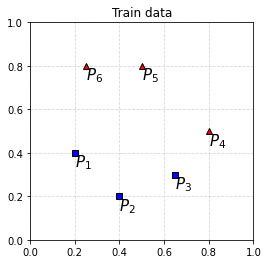

In [3]:
example_plot_wo_contour(xy, labels, 'Train data')

### 9.1.1 연속 확률 모델

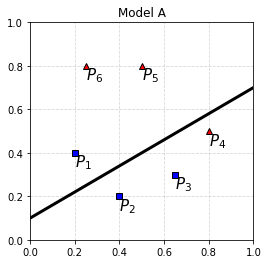

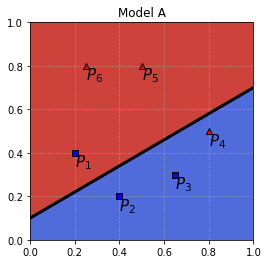

In [4]:
example_plot_only_line(xy, labels, 0.6, .1, 'Model A')
example_plot(xy, labels, 0.6, .1, 'Model A')

In [5]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable([[6.],[10.]]) # 기울기
        self.b = tf.Variable([-8.]) # y 절편

    def call(self, x): # x: 데이터 x 좌표
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)

In [6]:
model = MyModel()

pred = model(xy).numpy()
print(pred)
pred[0:3] = 1.0 - pred[0:3]
print(pred)
prob = np.prod(pred)
print(prob)

Metal device set to: Apple M1 Pro
[[0.05732416]
 [0.026597  ]
 [0.24973983]
 [0.858149  ]
 [0.95257413]
 [0.8175745 ]]
[[0.9426758 ]
 [0.973403  ]
 [0.7502602 ]
 [0.858149  ]
 [0.95257413]
 [0.8175745 ]]
0.46010378


2022-10-08 09:41:44.916823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-08 09:41:44.916935: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


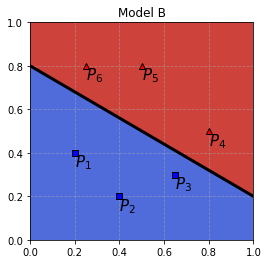

In [7]:
example_plot(xy, labels, -.6, .8, 'Model B')

In [8]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable([[1.],[10.]]) # 기울기
        self.b = tf.Variable([-5.]) # y 절편

    def call(self, x): # x: 데이터 x 좌표
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)

In [9]:
model = MyModel()

pred = model(xy).numpy()
print(pred)
pred[0:3] = 1.0 - pred[0:3]
print(pred)
prob = np.prod(pred)
print(prob)

[[0.31002548]
 [0.06913843]
 [0.20587039]
 [0.68997455]
 [0.9706878 ]
 [0.96267307]]
[[0.68997455]
 [0.9308616 ]
 [0.7941296 ]
 [0.68997455]
 [0.9706878 ]
 [0.96267307]]
0.32885242


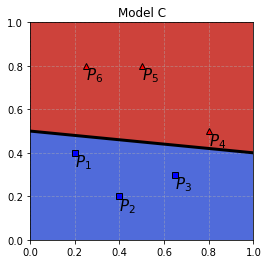

In [10]:
example_plot(xy, labels, -.1, .5, 'Model C')

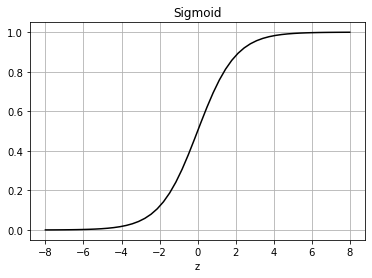

In [11]:
tmp = np.linspace(-8,8)
sigmoid = lambda z:  1.0 / (1+np.exp(-z))

plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(tmp, sigmoid(tmp), 'k')
plt.grid()
plt.xlabel('z')
plt.title('Sigmoid')
plt.show()

### 9.1.2 최대우도법과 크로스 엔트로피

In [12]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable([[6.],[10.]]) # 기울기
        self.b = tf.Variable([-8.]) # y 절편

    def call(self, x): # x: 데이터 x 좌표
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)

In [13]:
loss = lambda y, yhat: tf.reduce_mean(- y * tf.math.log(yhat) - (1 - y) * tf.math.log(1 - yhat))

In [14]:
model = MyModel()

pred = model(xy).numpy()
pred[0:3] = 1.0 - pred[0:3]
print(pred)
prob = np.prod(pred)
print(-np.log(prob), loss(labels, model(xy)).numpy() * len(xy) )

[[0.9426758 ]
 [0.973403  ]
 [0.7502602 ]
 [0.858149  ]
 [0.95257413]
 [0.8175745 ]]
0.77630323 0.7763031721115112


In [15]:
def plot_model(model, feature_labmda, title):
    from pandas import DataFrame
    xx, yy = np.meshgrid(np.linspace(-0.05,1.1,200), np.linspace(-0.05,1.1,200))
    input_xy = np.array([feature_labmda(xxval, yyval) for xxval, yyval in zip(xx.flatten(), yy.flatten())])
    prediction = model(input_xy).numpy()
    Z = prediction.reshape(xx.shape)
    df = DataFrame(dict(x=xy[:,0], y=xy[:,1], label=labels.flatten()))
    markers = {0:'bs', 1:'r^'}
    _, ax = plt.subplots(figsize=(5, 5))
    cs = ax.contourf(xx, yy, Z, 20, cmap='coolwarm', alpha=.9)
    ax.clabel(cs, colors='gray')
    cs = ax.contour(xx, yy, Z, cmap='gray', levels=[0, 0.5, 1.0], linestyles='--', linewidths=2)
    ax.clabel(cs, colors='k')
    predictions = model(xy).numpy()
    for k, xy0 in df[['x', 'y']].iterrows():
        x0, y0 = xy0.values
        plt.plot(x0, y0, markers[labels[k][0]], mec='k')
        plt.text(x0, y0, '$P_{}$\n({:1.0f}%)'.format(k+1, 100*predictions[k][0]), size=15, \
                 verticalalignment='top', horizontalalignment='left')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.grid(linestyle='--', alpha=0.5)
    plt.title(title)
    plt.show()

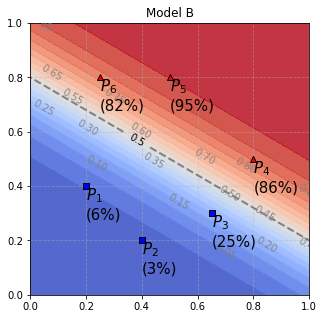

In [16]:
plot_model(model, lambda x,y: [x,y], 'Model B')

### 9.1.3 미니 배치 방법을 통한 모델 학습

In [17]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable([[1.],[1.]]) # 기울기
        self.b = tf.Variable([-1.]) # y 절편

    def call(self, x): # x: 데이터 x 좌표
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)

In [18]:
features = xy
loss = lambda y, yhat: tf.reduce_mean(- y * tf.math.log(yhat) - (1 - y) * tf.math.log(1 - yhat))

model = MyModel()

# 수치최적화 알고리즘
MaxEpochs = 50
lr = 1.0
optimizer = tf.keras.optimizers.Adam(lr)

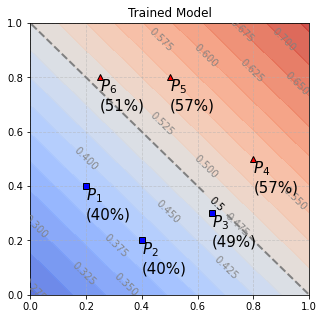

In [19]:
plot_model(model, lambda x,y: [x,y], 'Trained Model')

In [20]:
from helper import generate_batches

# 데이터 섞기
np.random.seed(320)
shuffled_id = np.arange(0, len(features))
np.random.shuffle(shuffled_id)
shuffled_x_train = features[shuffled_id]
shuffled_y_train = labels[shuffled_id]

# 스토캐스틱 방법
batch_size = 10
for epoch in range(MaxEpochs):
    if epoch % 5 == 0:
        curr_loss = loss(labels, model(features))
        print(model.w.numpy().T, model.b.numpy(), curr_loss.numpy())

    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train):
        with tf.GradientTape() as tape:
            curr_loss = loss(y_batch, model(x_batch))
            gradients = tape.gradient(curr_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

[[1. 1.]] [-1.] 0.5786101
[[0.25677967 2.7252657 ]] [-2.2425652] 0.52684945
[[1.2269706 5.8030467]] [-2.5118606] 0.358742
[[0.7806215 7.2956047]] [-4.387375] 0.25905645
[[1.9247484 9.4247465]] [-5.050705] 0.18241966
[[ 2.56125  10.770846]] [-6.1915245] 0.13992913
[[ 3.0603068 11.742341 ]] [-7.36981] 0.11699116
[[ 4.0667257 12.919675 ]] [-7.9655857] 0.09489195
[[ 4.622793 13.727049]] [-8.742782] 0.080527104
[[ 4.9657044 14.368752 ]] [-9.512309] 0.07120554


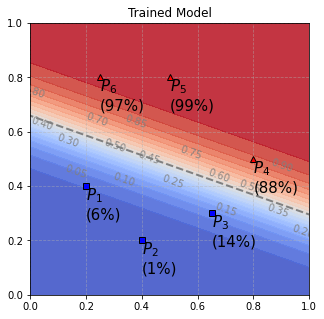

In [21]:
plot_model(model, lambda x,y: [x,y], 'Trained Model')

### 9.1.4 특성값을 이용한 비선형 분류 모델

In [22]:
from sklearn.datasets import make_circles
xy, labels = make_circles(n_samples=400, noise=0.1)

In [23]:
# 특성값 정의
features = np.array([[xval**2, yval**2] for xval, yval in xy])
loss = lambda y, yhat: tf.reduce_mean(- y * tf.math.log(yhat) - (1 - y) * tf.math.log(1 - yhat))

In [24]:
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable([[1.],[1.]]) # 기울기
        self.b = tf.Variable([-0.25]) # y 절편

    def call(self, x): # x: 데이터 x 좌표
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)

In [25]:
model = MyModel()

In [26]:
def plot_model(model, feature_labmda, title):
    from pandas import DataFrame
    xx, yy = np.meshgrid(np.linspace(-1.5,1.5, 200), np.linspace(-1.5,1.5, 200))
    inputs_xy = np.array([feature_labmda(xxval, yyval) for xxval, yyval in zip(xx.flatten(), yy.flatten())])
    prediction = model(inputs_xy).numpy()
    Z = prediction.reshape(xx.shape)
    df = DataFrame(dict(x=xy[:,0], y=xy[:,1], label=labels.flatten()))
    colors = {0:'red', 1:'blue'}
    markers = {0:'bs', 1:'r^'}
    _, ax = plt.subplots(figsize=(5, 5))
    ax.contourf(xx, yy, Z, 5, cmap='coolwarm', alpha=.9)
    cs = ax.contour(xx, yy, Z, cmap='gray', levels=[0, 0.5, 1.0], linestyles='--', linewidths=2)
    ax.clabel(cs, colors='k')
    grouped = df.groupby('label')
    for k, xy0 in df[['x', 'y']].iterrows():
        x0, y0 = xy0.values
        plt.plot(x0, y0, markers[labels[k]], mec='k', alpha=0.6)
    ax.set_xlim([-1.3, 1.3])
    ax.set_ylim([-1.3, 1.3])
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.show()

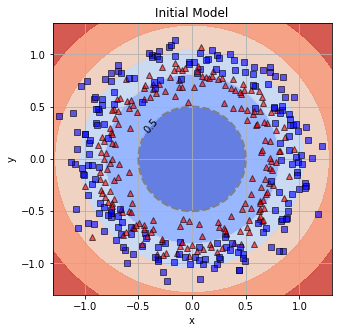

In [27]:
model = MyModel()
plot_model(model, lambda x,y: [x**2, y**2], 'Initial Model')

# 수치최적화 알고리즘
MaxEpochs = 100
lr = 0.01
optimizer = tf.keras.optimizers.Adam(lr)

# 데이터 섞기
np.random.seed(320)
shuffled_id = np.arange(0, len(features))
np.random.shuffle(shuffled_id)
shuffled_x_train = features[shuffled_id]
shuffled_y_train = labels[shuffled_id]

# 스토캐스틱 방법
batch_size = 10
for epoch in range(MaxEpochs):
    for x_batch, y_batch in generate_batches(batch_size, shuffled_x_train, shuffled_y_train):
        with tf.GradientTape() as tape:
            curr_loss = loss(y_batch, model(x_batch))
            gradients = tape.gradient(curr_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

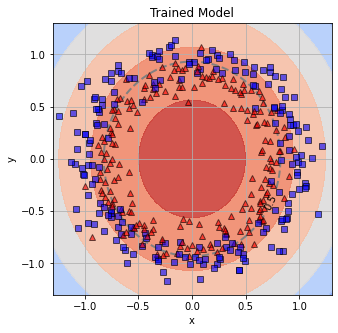

In [28]:
plot_model(model, lambda x,y: [x**2, y**2], 'Trained Model')